In [1]:
import numpy as np
import cv2
import random
import tensorflow as tf
import shutil
from keras_facenet import FaceNet
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
import shutil
from numpy.random import seed
seed(1)

tf.random.set_seed(1)

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# import function to perform linear regression
from sklearn.linear_model import LinearRegression

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler 

# import SGDRegressor from sklearn to perform linear regression with stochastic gradient descent
from sklearn.linear_model import SGDRegressor

# import function for ridge regression
from sklearn.linear_model import Ridge

# import function for lasso regression
from sklearn.linear_model import Lasso

# import function for elastic net regression
from sklearn.linear_model import ElasticNet

# import function to perform GridSearchCV
from sklearn.model_selection import GridSearchCV

# import functions to perform cross validation
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
project_path='C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\'  

In [14]:
images_zip_path = project_path + "DD Kaggle Data.zip"
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [21]:
import os
source='C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\'

In [24]:
os.chdir('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\')
if os.path.isdir('Train\\alert') is False:
    os.mkdir('Train')
    os.mkdir('Test')
    os.mkdir('Valid')

In [25]:
files=os.listdir(source)
files 

['alert', 'drowsy', 'Test', 'Train', 'Valid']

In [27]:
for i in files:                                                       #deeplizard
    shutil.move(f'{i}','Train')
    os.mkdir(f'Test/{i}')
    os.mkdir(f'Valid/{i}')
        
    valid_samples = random.sample(os.listdir(f'Train/{i}'),193)
    for j in valid_samples:
        shutil.move(f'Train/{i}/{j}',f'Valid/{i}')
            
    test_samples = random.sample(population=os.listdir(f'Train/{i}'),k=96)
    for l in test_samples:
        shutil.move(f'Train/{i}/{l}',f'Test/{i}')   
os.chdir('../..')

In [4]:
def plot_confusion_matrix(cm, classes,
                         normalise=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalise:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalised Confusion Matrix')
    else:
        print('Confusion Matrix without normalisation')
    
    print(cm)
    
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], color='white' if cm[i][j] > thresh else 'black')
        
class_labels=['alert', 'drowsy']

In [5]:
def plot_history(hist):
    plt.figure(figsize=(20,10))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    
    plt.show()
    

In [4]:
project_path='C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\'  
files =  os.listdir(project_path)
print(files)
train_path=os.path.join(project_path,os.listdir(project_path)[1])
valid_path=os.path.join(project_path,os.listdir(project_path)[2])
test_path=os.path.join(project_path,os.listdir(project_path)[0])

['Test', 'Train', 'Valid']


In [5]:
train_path, valid_path, test_path

('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Train',
 'C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Valid',
 'C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test')

### MobileNet Implementation

In [6]:
# pre-processing the dataset
train_set=ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = train_path, target_size=(224,224), batch_size=10)

valid_set=ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = valid_path, target_size=(224,224), batch_size=10)

test_set =ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = test_path, target_size=(224,224), batch_size=10)

Found 1075 images belonging to 2 classes.
Found 386 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [8]:
x=mobile.layers[-6].output
# x=Dense(800, activation='relu')(x)
# x=Dense(400, activation='relu')(x)
# x=Dense(100, activation='relu')(x)
output=Dense(units=2, activation='softmax')(x)

In [9]:
mn_model=Model(inputs= mobile.input,outputs=output)
mn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [10]:
for layer in mn_model.layers[:-20]:      #15 layers--initially; 
    layer.trainable=False
mn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

### Training the Model

In [11]:
mn_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
#     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
# ]

In [12]:
mob_model=mn_model.fit(x=train_set, steps_per_epoch=4, validation_steps=4, validation_data=valid_set,  epochs=50, verbose=2)   # , callbacks=callbacks8.42 - 

Epoch 1/50
4/4 - 6s - loss: 2.3307 - accuracy: 0.5750 - val_loss: 12.6431 - val_accuracy: 0.5500
Epoch 2/50
4/4 - 5s - loss: 1.1234 - accuracy: 0.7000 - val_loss: 9.3334 - val_accuracy: 0.4750
Epoch 3/50
4/4 - 5s - loss: 0.3301 - accuracy: 0.9250 - val_loss: 5.1057 - val_accuracy: 0.5250
Epoch 4/50
4/4 - 5s - loss: 0.1003 - accuracy: 0.9750 - val_loss: 8.7797 - val_accuracy: 0.4000
Epoch 5/50
4/4 - 5s - loss: 0.0708 - accuracy: 0.9750 - val_loss: 8.5721 - val_accuracy: 0.5000
Epoch 6/50
4/4 - 5s - loss: 0.0187 - accuracy: 1.0000 - val_loss: 12.0159 - val_accuracy: 0.3500
Epoch 7/50
4/4 - 5s - loss: 0.1211 - accuracy: 0.9500 - val_loss: 7.3568 - val_accuracy: 0.6000
Epoch 8/50
4/4 - 5s - loss: 0.1598 - accuracy: 0.9250 - val_loss: 7.6804 - val_accuracy: 0.5750
Epoch 9/50
4/4 - 4s - loss: 0.0304 - accuracy: 0.9714 - val_loss: 8.8241 - val_accuracy: 0.4000
Epoch 10/50
4/4 - 4s - loss: 0.1194 - accuracy: 0.9750 - val_loss: 7.4061 - val_accuracy: 0.5250
Epoch 11/50
4/4 - 4s - loss: 0.0127 -

### Testing

In [13]:
test_set.class_indices

{'alert': 0, 'drowsy': 1}

In [14]:
test_labels= test_set.classes
predictions= mn_model.predict(x=test_set, verbose=0)
predictions

array([[4.08456521e-03, 9.95915473e-01],
       [9.99986649e-01, 1.32930963e-05],
       [1.12677062e-05, 9.99988675e-01],
       [9.99999046e-01, 9.21921526e-07],
       [1.00000000e+00, 2.54619353e-10],
       [1.00000000e+00, 2.74720635e-10],
       [1.32870744e-03, 9.98671293e-01],
       [1.00000000e+00, 3.11643662e-11],
       [9.99999762e-01, 2.28194779e-07],
       [7.55142025e-07, 9.99999285e-01],
       [1.00000000e+00, 1.24763672e-10],
       [9.99879837e-01, 1.20162600e-04],
       [1.00000000e+00, 1.11848530e-10],
       [4.39795758e-06, 9.99995589e-01],
       [6.83267973e-03, 9.93167341e-01],
       [1.33726439e-06, 9.99998689e-01],
       [9.99991417e-01, 8.56347015e-06],
       [1.50616752e-05, 9.99984980e-01],
       [4.52908125e-06, 9.99995470e-01],
       [1.00000000e+00, 1.34114471e-08],
       [1.00000000e+00, 2.11917081e-10],
       [9.91661906e-01, 8.33803229e-03],
       [1.05634557e-04, 9.99894381e-01],
       [9.99916077e-01, 8.39098138e-05],
       [7.191055

In [146]:
test_labels= test_set.classes
predictions= mn_model.predict(x=test_set, verbose=0)
predictions

array([[0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.88225335, 0.11774662],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.9713164 , 0.02868356],
       [0.05670442, 0.9432956 ],
       [0.05670442, 0.9432956 ],
       [0.

In [147]:
# For last 15 layers opened

Confusion Matrix without normalisation
[[51 45]
 [45 51]]


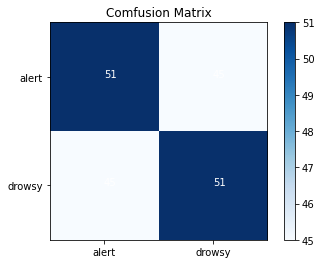

In [148]:
cm= confusion_matrix(y_true=test_labels, y_pred= predictions.argmax(axis=1))
plot_confusion_matrix(cm, classes=class_labels, title='Comfusion Matrix')

<Figure size 1440x720 with 0 Axes>

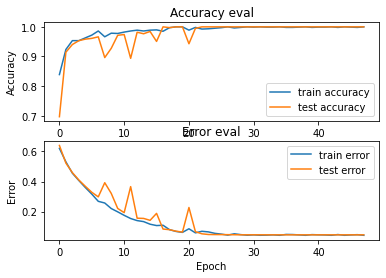

In [149]:
plot_history(mob_model) # 50 epochs

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg
[[0.7594153  0.24058472]]


('alert', 0.7594153)

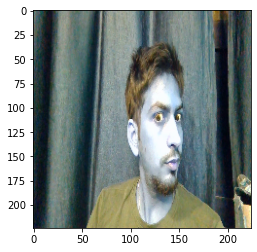

In [82]:
from PIL import Image

#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = mn_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

In [81]:
# saving the model
# mn_model.save('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/mob_model')

mn_model = tf.keras.models.load_model('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/mob_model')
mn_model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

### vGG16

In [8]:
vgg_train_set=ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = train_path, target_size=(224,224), batch_size=10)

vgg_valid_set=ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = valid_path, target_size=(224,224), batch_size=10)

vgg_test_set =ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory = test_path, target_size=(224,224), batch_size=10)

Found 1075 images belonging to 2 classes.
Found 386 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [48]:
vgg16_model= tf.keras.applications.vgg16.VGG16()

In [49]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [50]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [51]:
vgg_model=Sequential()
for layer in vgg16_model.layers:
    vgg_model.add(layer)
type(vgg_model)

tensorflow.python.keras.engine.sequential.Sequential

In [52]:
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [53]:
vgg_model.layers.pop()

In [54]:
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [55]:
for layer in vgg_model.layers[:-1]:
    layer.trainable=False

In [56]:
vgg_model.add(Dense(800, activation='relu'))
vgg_model.add(Dense(400, activation='relu'))
vgg_model.add(Dense(100, activation='relu'))
vgg_model.add(Dense(2, activation='softmax'))

In [57]:
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Training the model

In [59]:
vgg_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
#     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
# ]

In [60]:
vgg16_model= vgg_model.fit(x=vgg_train_set, steps_per_epoch=5, validation_steps=4, validation_data=vgg_valid_set, epochs=50, verbose=2) # , callbacks=callbacks
# 9.17 - 

Epoch 1/50
5/5 - 15s - loss: 0.6898 - accuracy: 0.6400 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/50
5/5 - 15s - loss: 0.6836 - accuracy: 0.6600 - val_loss: 0.6836 - val_accuracy: 0.5750
Epoch 3/50
5/5 - 15s - loss: 0.6803 - accuracy: 0.6200 - val_loss: 0.6867 - val_accuracy: 0.5250
Epoch 4/50
5/5 - 15s - loss: 0.6824 - accuracy: 0.5400 - val_loss: 0.6999 - val_accuracy: 0.3750
Epoch 5/50
5/5 - 16s - loss: 0.6682 - accuracy: 0.5800 - val_loss: 0.6739 - val_accuracy: 0.5250
Epoch 6/50
5/5 - 16s - loss: 0.6312 - accuracy: 0.7200 - val_loss: 0.6793 - val_accuracy: 0.3750
Epoch 7/50
5/5 - 16s - loss: 0.6191 - accuracy: 0.6600 - val_loss: 0.6790 - val_accuracy: 0.4250
Epoch 8/50
5/5 - 16s - loss: 0.5917 - accuracy: 0.6600 - val_loss: 0.6267 - val_accuracy: 0.5750
Epoch 9/50
5/5 - 16s - loss: 0.5629 - accuracy: 0.7400 - val_loss: 0.5991 - val_accuracy: 0.7000
Epoch 10/50
5/5 - 16s - loss: 0.5573 - accuracy: 0.8400 - val_loss: 0.6006 - val_accuracy: 0.7250
Epoch 11/50
5/5 - 16s - loss:

In [88]:
vgg_model.save('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/vgg_model')

# vgg_model = tf.keras.models.load_model('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/vgg_model')
# vgg_model.summary()


INFO:tensorflow:Assets written to: C:\Users\hp\Documents\Data Science\SEM 3\Major Project\Drowsiness detection files\First Approach\Saved_models/vgg_model\assets


### Prediction using VGG16

In [65]:
# test_labels= vgg_test_set.classes             # test_imgs, test_labels = next(vgg_test_set)
# test_labels=test_labels[:,0]                  # cm=confusion_matrix(test_labels, np.round(predictions[:,0]))
# print(test_labels)                            # cm_plot_labels=['alert','drowsy']
#                                               # plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
#                                               # predictions= vgg_model.predict(x=vgg_test_set, verbose=0)
#                                               # print(predictions)              

In [64]:
test_labels= vgg_test_set.classes
predictions= vgg_model.predict(x=vgg_test_set, verbose=0)
predictions

array([[0.99871564, 0.00128442],
       [0.9987663 , 0.00123374],
       [0.99860734, 0.00139269],
       [0.9986638 , 0.0013362 ],
       [0.9982835 , 0.00171658],
       [0.99817526, 0.00182472],
       [0.02522042, 0.9747796 ],
       [0.9985777 , 0.00142227],
       [0.01306312, 0.98693687],
       [0.09782787, 0.90217215],
       [0.01198054, 0.9880194 ],
       [0.99847645, 0.00152354],
       [0.9834462 , 0.01655384],
       [0.01531416, 0.9846859 ],
       [0.03833611, 0.96166396],
       [0.01175826, 0.98824173],
       [0.99867475, 0.00132531],
       [0.01509517, 0.9849049 ],
       [0.9987398 , 0.00126024],
       [0.03047076, 0.9695292 ],
       [0.0231781 , 0.97682184],
       [0.99864143, 0.00135862],
       [0.01811565, 0.9818843 ],
       [0.01179623, 0.98820376],
       [0.02612221, 0.9738777 ],
       [0.09664877, 0.90335125],
       [0.01422977, 0.9857702 ],
       [0.99859375, 0.00140628],
       [0.01873057, 0.98126936],
       [0.9987087 , 0.00129131],
       [0.

<Figure size 1440x720 with 0 Axes>

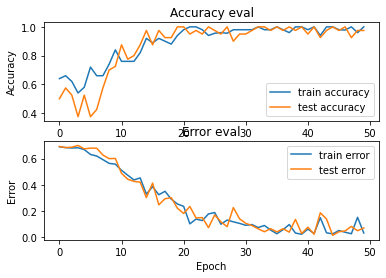

In [67]:
plot_history(vgg16_model)

Confusion Matrix without normalisation
[[50 46]
 [49 47]]


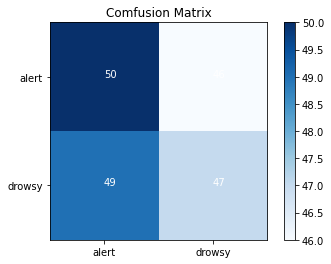

In [68]:
cm= confusion_matrix(y_true=test_labels, y_pred= predictions.argmax(axis=1))
plot_confusion_matrix(cm, classes=class_labels, title='Comfusion Matrix')

### Testing

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\drowsy\\drowsy99.jpg
[[0.01974221 0.9802578 ]]


('drowsy', 0.9802578)

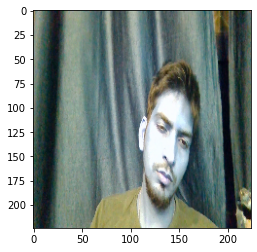

In [84]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = vgg_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert115.jpg
[[0.94319516 0.0568048 ]]


('alert', 0.94319516)

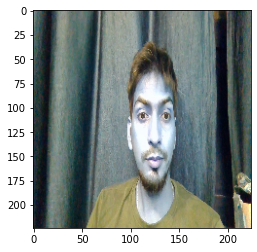

In [87]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = vgg_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

### CNN 

In [89]:
train_path, valid_path, test_path

('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Train',
 'C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Valid',
 'C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test')

In [90]:
cnn_train_set=ImageDataGenerator().flow_from_directory(directory = train_path, target_size=(224,224), batch_size=8, classes=['alert','drowsy'])

cnn_valid_set=ImageDataGenerator().flow_from_directory(directory = valid_path, target_size=(224,224), batch_size=4,classes=['alert','drowsy'])

cnn_test_set =ImageDataGenerator().flow_from_directory(directory = test_path, target_size=(224,224), batch_size=4,classes=['alert','drowsy'])

Found 1075 images belonging to 2 classes.
Found 386 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [91]:
imgs, labels=next(cnn_train_set)

In [199]:
cnn_model=Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax') ])
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_6 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [104]:
cnn_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
cnn_hist=cnn_model.fit(cnn_train_set, steps_per_epoch=10, validation_data=cnn_valid_set, validation_steps=10, epochs=50, verbose=2)

Epoch 1/50
10/10 - 4s - loss: 1757.4723 - accuracy: 0.4750 - val_loss: 656.5433 - val_accuracy: 0.4500
Epoch 2/50
10/10 - 4s - loss: 312.8335 - accuracy: 0.7000 - val_loss: 223.9150 - val_accuracy: 0.7500
Epoch 3/50
10/10 - 4s - loss: 301.6584 - accuracy: 0.7750 - val_loss: 508.1033 - val_accuracy: 0.6750
Epoch 4/50
10/10 - 4s - loss: 179.3978 - accuracy: 0.7875 - val_loss: 84.8021 - val_accuracy: 0.8000
Epoch 5/50
10/10 - 4s - loss: 67.0383 - accuracy: 0.8500 - val_loss: 43.0805 - val_accuracy: 0.8500
Epoch 6/50
10/10 - 4s - loss: 79.4480 - accuracy: 0.8125 - val_loss: 71.4367 - val_accuracy: 0.8750
Epoch 7/50
10/10 - 4s - loss: 77.8254 - accuracy: 0.8750 - val_loss: 18.7880 - val_accuracy: 0.9750
Epoch 8/50
10/10 - 4s - loss: 135.7398 - accuracy: 0.7500 - val_loss: 8.4018 - val_accuracy: 0.9500
Epoch 9/50
10/10 - 4s - loss: 52.5588 - accuracy: 0.9125 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/50
10/10 - 4s - loss: 25.8207 - accuracy: 0.9375 - val_loss: 37.1446 - val_accur

In [107]:
test_labels= cnn_test_set.classes
predictions= cnn_model.predict(x=cnn_test_set, verbose=0)
predictions

array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [6.6663694e-23, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.

<Figure size 1440x720 with 0 Axes>

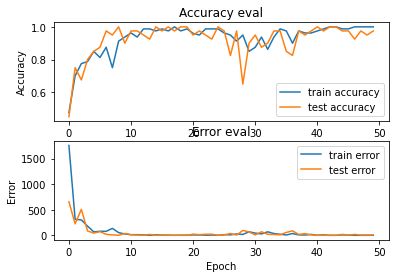

In [108]:
plot_history(cnn_hist)   #steps_per_epoch= 10    , validation_steps= 10

Confusion Matrix without normalisation
[[51 45]
 [49 47]]


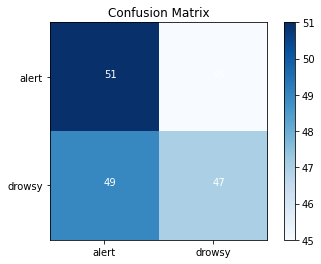

In [109]:
cm= confusion_matrix(y_true=test_labels, y_pred= predictions.argmax(axis=1))
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg
[[1. 0.]]


('alert', 1.0)

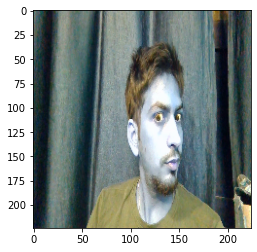

In [110]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = cnn_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\drowsy\\drowsy99.jpg
[[0. 1.]]


('drowsy', 1.0)

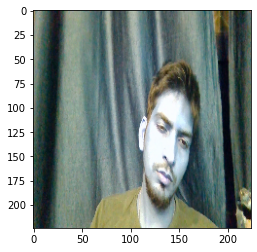

In [130]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\drowsy\\drowsy99.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = cnn_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

In [114]:
cnn_model.save('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/cnn1_model')

# cnn1_model = tf.keras.models.load_model('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/cnn1_model')
# cnn1_model.summary()


INFO:tensorflow:Assets written to: C:\Users\hp\Documents\Data Science\SEM 3\Major Project\Drowsiness detection files\First Approach\Saved_models/cnn1_model\assets


### CNN2

In [120]:
cnn2_model = Sequential()
cnn2_model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = (224,224,3)))
cnn2_model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
cnn2_model.add(BatchNormalization())

cnn2_model.add(Conv2D(32, (3, 3), activation = "relu"))
cnn2_model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
cnn2_model.add(Dropout(0.3))

cnn2_model.add(Conv2D(32, (2, 2), activation = "relu"))
cnn2_model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
cnn2_model.add(BatchNormalization())

cnn2_model.add(Conv2D(16, (1, 1), activation = "relu"))
cnn2_model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
cnn2_model.add(BatchNormalization())

cnn2_model.add(Flatten())
cnn2_model.add(Dense(64, activation="relu"))
cnn2_model.add(Dropout(0.3))
cnn2_model.add(Dense(2, activation="softmax"))

cnn2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 54, 54, 32)       

In [121]:
cnn2_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
cnn2_hist=cnn2_model.fit(cnn_train_set, steps_per_epoch=10, validation_data=cnn_valid_set, validation_steps=10, epochs=50, verbose=2)

Epoch 1/50
10/10 - 8s - loss: 0.7081 - accuracy: 0.6750 - val_loss: 0.9191 - val_accuracy: 0.5000
Epoch 2/50
10/10 - 8s - loss: 0.5741 - accuracy: 0.7375 - val_loss: 0.9453 - val_accuracy: 0.6000
Epoch 3/50
10/10 - 8s - loss: 0.2958 - accuracy: 0.9000 - val_loss: 0.7090 - val_accuracy: 0.6500
Epoch 4/50
10/10 - 8s - loss: 0.4188 - accuracy: 0.8625 - val_loss: 0.6338 - val_accuracy: 0.7500
Epoch 5/50
10/10 - 7s - loss: 0.3298 - accuracy: 0.8750 - val_loss: 0.8622 - val_accuracy: 0.7000
Epoch 6/50
10/10 - 8s - loss: 0.3477 - accuracy: 0.8750 - val_loss: 0.4164 - val_accuracy: 0.8500
Epoch 7/50
10/10 - 8s - loss: 0.2077 - accuracy: 0.8875 - val_loss: 0.4592 - val_accuracy: 0.8000
Epoch 8/50
10/10 - 8s - loss: 0.2520 - accuracy: 0.9125 - val_loss: 0.5655 - val_accuracy: 0.8000
Epoch 9/50
10/10 - 7s - loss: 0.1929 - accuracy: 0.9250 - val_loss: 0.3911 - val_accuracy: 0.8500
Epoch 10/50
10/10 - 7s - loss: 0.1490 - accuracy: 0.9375 - val_loss: 0.2399 - val_accuracy: 0.9250
Epoch 11/50
10/10 -

In [124]:
test_labels= cnn_test_set.classes
predictions= cnn2_model.predict(x=cnn_test_set, verbose=0)
predictions

array([[9.96135771e-01, 3.86416167e-03],
       [9.96984303e-01, 3.01567325e-03],
       [2.57082079e-02, 9.74291861e-01],
       [9.96114731e-01, 3.88526614e-03],
       [9.99387741e-01, 6.12277072e-04],
       [9.98097599e-01, 1.90244615e-03],
       [9.98888910e-01, 1.11114944e-03],
       [6.27552951e-03, 9.93724525e-01],
       [4.09222860e-03, 9.95907784e-01],
       [9.96951938e-01, 3.04806698e-03],
       [9.97911632e-01, 2.08830601e-03],
       [2.57556457e-02, 9.74244297e-01],
       [5.95348738e-02, 9.40465093e-01],
       [8.45796487e-04, 9.99154210e-01],
       [1.68242604e-02, 9.83175755e-01],
       [5.58340829e-03, 9.94416595e-01],
       [9.97670114e-01, 2.32989737e-03],
       [2.91669113e-03, 9.97083247e-01],
       [6.18973328e-03, 9.93810236e-01],
       [9.65840518e-01, 3.41594666e-02],
       [1.56664304e-04, 9.99843359e-01],
       [9.44271218e-04, 9.99055684e-01],
       [9.98058975e-01, 1.94098707e-03],
       [2.85500777e-03, 9.97144997e-01],
       [9.966187

<Figure size 1440x720 with 0 Axes>

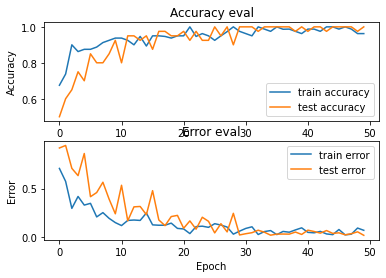

In [125]:
plot_history(cnn2_hist)   #steps_per_epoch= 10    , validation_steps= 10

Confusion Matrix without normalisation
[[46 50]
 [49 47]]


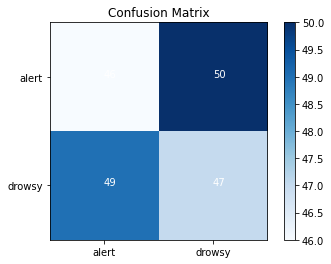

In [126]:
cm= confusion_matrix(y_true=test_labels, y_pred= predictions.argmax(axis=1))
plot_confusion_matrix(cm, classes=class_labels, title='Confusion Matrix')

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg
[[0.9989347  0.00106529]]


('alert', 0.9989347)

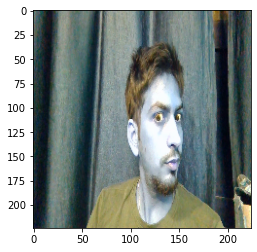

In [127]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\alert\\alert154.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = cnn2_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

Please enter the test image with full path: C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\drowsy\\drowsy99.jpg
[[0.01525667 0.98474336]]


('drowsy', 0.98474336)

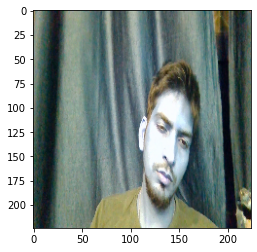

In [129]:
#  C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First dataset\\Test\\drowsy\\drowsy99.jpg

test_img = input('Please enter the test image with full path: ')


def decode_prediction():
#     from PIL import Image
#     test_image = Image.open(input('Please enter the test image with full path: '))
#     test_image.show

    test_image = cv2.resize(cv2.imread(test_img), (224,224))
    plt.imshow(test_image)
    test_image =np.array(test_image).reshape(-1, 224,224,3)
    prediction = cnn2_model.predict({'input':test_image})
    print(prediction)
    if prediction[0][1]>= 0.6 :
        output = 'drowsy'
        return output, prediction[0][1]
    else: 
        output = 'alert' 
        return output, prediction[0][0]

decode_prediction()

In [128]:
cnn2_model.save('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/cnn2_model')

# cnn2_model = tf.keras.models.load_model('C:\\Users\\hp\\Documents\\Data Science\\SEM 3\\Major Project\\Drowsiness detection files\\First Approach\\Saved_models/cnn2_model')
# cnn2_model.summary()


INFO:tensorflow:Assets written to: C:\Users\hp\Documents\Data Science\SEM 3\Major Project\Drowsiness detection files\First Approach\Saved_models/cnn2_model\assets
